In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister,ClassicalRegister
from qiskit.quantum_info import Statevector, Operator, partial_trace
from qiskit.circuit import Measure
import itertools
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Sampler
from qiskit.primitives import SamplerResult
from qiskit.providers.basic_provider import BasicProvider
from qiskit import transpile
from qiskit_aer import Aer
from numpy import random
from collections import Counter
from qiskit_aer.primitives import SamplerV2
from qiskit.visualization import plot_histogram, array_to_latex
from latticecode import *
from KitaevToricCode import *

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error


In [2]:
# p_error = random.random()

p_error = 0.04
print(p_error)

0.04


In [3]:
# bit_flip = pauli_error([('X', p), ('Y', p), ('Z', p), ('I', 1-3*p)])

# noise = NoiseModel()
# noise.add_all_qubit_quantum_error(bit_flip, ['id'])
# noisy_sim = AerSimulator(method='stabilizer', noise_model=noise)

In [4]:
noise_model = NoiseModel()

p_error = 0.05
bit_flip = pauli_error([("X", p_error), ("I", 1 - p_error)])
phase_flip = pauli_error([("Z", p_error), ("I", 1 - p_error)])

noise_model.add_all_qubit_quantum_error(bit_flip, ['id'])
noise_model.add_all_qubit_quantum_error(phase_flip, ['id'])




In [5]:
x0 = 0
x1 = 0
k0 = 3
k1 = 3

LatticeCircuit = KitaevToricModel(x0, x1,k0,k1, p_error)


job = AerSimulator().run(LatticeCircuit, shots=1, memory=True)

result = job.result()
memory = result.get_memory(LatticeCircuit)

memory_result = memory[0]

print(memory_result)
if memory_result[0:2] == str(x0) + str(x1):
    print( 'No logical error has been observed' )


00 000000011
No logical error has been observed


In [6]:
px = py = pz = 0.3
x0 = 1
x1 = 1
k0 = 3
k1 = 3
LatticeCircuit = KitaevToricModel(x0, x1,k0,k1, p_error)

pauli_errors = pauli_error([('X', px), ('Y', py), ('Z', pz), ('I', 1-px-py-pz)])

noise = NoiseModel()
noise.add_all_qubit_quantum_error(pauli_errors, ['id'])
noisy_sim = AerSimulator(noise_model=noise)

noisy_circuit = transpile(LatticeCircuit, noisy_sim, optimization_level=0)

nShots = 1000
result = noisy_sim.run(noisy_circuit, shots=nShots).result()
counts = result.get_counts()


In [7]:
print(counts)

{'10 001100110': 1000}


In [8]:

# error_params = {'X_max': 3, 'Z_max' : 3}
# num_shots = 5000


def execute_model(x_0,x_1, k0,k1 , p_error, num_shots, success=True):
    success_rate = 0
    for i in range(num_shots):
        LatticeCircuit = KitaevToricModel(x_0, x_1, k0,k1, p_error, error=True)
        
        # transpiled = transpile(LatticeCircuit)
        # job = AerSimulator().run(transpiled, shots=1, memory=True)
        job = AerSimulator().run(LatticeCircuit, shots=1, memory=True)
        
        result = job.result()
        memory = result.get_memory(LatticeCircuit)

        memory_result = memory[0]
        
    
        # simulator = AerSimulator()
        # job = simulator.run(LatticeCircuit, shots=1)
        # counts = job.result().get_counts()
        # result = list(dict(counts).keys())[0][0 : 2*k0*k1 ]
        
        
        if memory_result[0:2] == str(x_0) + str(x_1):
            success_rate += 1     
            
    if success == True:      
        return  success_rate/num_shots
    
    if success == False:
        return 1 - (success_rate/num_shots) 

        
# output = execute_model(0,0,7,7,0.05 , 1000 , success=False)

In [9]:
output = execute_model(0,0,3,3,0.05 , 200 , success=False)
print(output)

0.485


In [10]:
output = execute_model(0,0,3,3,0.05/3,500 , success=True)
print(output)

0.79


In [11]:

# def execute_modelv2(x_0,x_1, k0,k1 , p_error, num_shots, success=True):
#     success_rate = 0
    
#     LatticeCircuit = KitaevToricModel(x_0, x_1, k0,k1, p_error, error=False)
#     qubits = LatticeCircuit.qubits
#     qc = QuantumCircuit(qubits)
    
#     for i in range(num_shots):
        
#         ApplyPauliError(qc, qubits[0: 2*k0*k1], p_error)
#         qc.compose(LatticeCircuit,inplace=True)
        
#         # transpiled = transpile(LatticeCircuit)
#         # job = AerSimulator().run(transpiled, shots=1, memory=True)
#         job = AerSimulator().run(qc, shots=1, memory=True)
        
#         result = job.result()
#         memory = result.get_memory(qc)

#         memory_result = memory[0]
        
    
#         # simulator = AerSimulator()
#         # job = simulator.run(LatticeCircuit, shots=1)
#         # counts = job.result().get_counts()
#         # result = list(dict(counts).keys())[0][0 : 2*k0*k1 ]
        
        
#         if memory_result[0:2] == str(x_0) + str(x_1):
#             success_rate += 1     
            
#     if success == True:      
#         return  success_rate/num_shots
    
#     if success == False:
#         return 1 - (success_rate/num_shots) 

        

In [12]:
# output = execute_modelv2(0,0,3,3,0.05 , 200 , success=False)
# print(output)

In [13]:

def execute_model_aer(x_0,x_1, k0,k1 , px,py,pz , success=True):
    success_rate = 0
    
    LatticeCircuit = KitaevToricModel(x_0, x_1, k0,k1, 0.05)
    pauli_errors = pauli_error([('X', px), ('Y', py), ('Z', pz), ('I', 1-px-py-pz)])
    noise = NoiseModel()
    noise.add_all_qubit_quantum_error(pauli_errors, ['id'])
    noisy_sim = AerSimulator(method='stabilizer', noise_model=noise)

    noisy_circuit = transpile(LatticeCircuit, noisy_sim, optimization_level=0)

    nShots = 200
    result = noisy_sim.run(noisy_circuit, shots=nShots, memory=True).result()       
    counts = result.get_counts()
    
    for key in counts.keys():
        output_read = key[0:2]
        if output_read == str(x_0) + str(x_1):
            success_rate += int(counts[key])
            
        
        # transpiled = transpile(LatticeCircuit)
        # job = AerSimulator().run(transpiled, shots=1, memory=True)
        # job = AerSimulator().run(LatticeCircuit, shots=num_shots, memory=True)
        
        # result = job.result()
        
    # memory = result.get_memory(noisy_circuit)
    
    # memory_result = memory[0]
    # print(memory_result[0:2])
    
        # simulator = AerSimulator()
        # job = simulator.run(LatticeCircuit, shots=1)
        # counts = job.result().get_counts()
        # result = list(dict(counts).keys())[0][0 : 2*k0*k1 ]
        
    
    # if memory_result[0:2] == str(x_0) + str(x_1):
    #     success_rate += 1     
        
    if success == True:      
        return  (success_rate/200)*100

    if success == False:
        return (1 - (success_rate/200))*100


In [14]:
# output = execute_model_aer(0,0,5,5,0.15,0.015,0.015, success=True)
# print(output)

In [15]:
# LatticeCircuit = KitaevToricModel(x0, x1,k0,k1, p_error)

# pauli_errors = pauli_error([('X', px), ('Y', py), ('Z', pz), ('I', 1-px-py-pz)])

# noise = NoiseModel()
# noise.add_all_qubit_quantum_error(pauli_errors, ['id'])
# noisy_sim = AerSimulator(method='stabilizer', noise_model=noise)

# noisy_circuit = transpile(LatticeCircuit, noisy_sim, optimization_level=0)

# nShots = 200
# result = noisy_sim.run(noisy_circuit, shots=nShots).result()
# counts = result.get_counts()

In [16]:
0.28800000000000003

0.28800000000000003

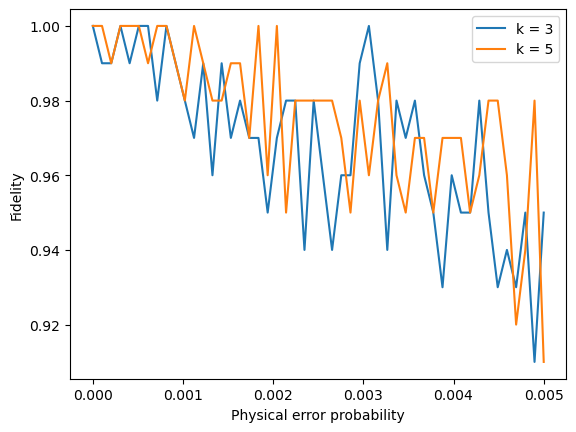

In [18]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.linspace(0, 0.005, 50)

# success_rates_7x7 =  [execute_model(x_0,x_1,7,7,p,100, success=False) for p in error_rates]
success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p,100) for p in error_rates]
# success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p,100) for p in error_rates]
success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p,100) for p in error_rates]

plt.figure()
line1, = plt.plot(error_rates, success_rates_3x3, label='k = 3' )
# line2, = plt.plot(error_rates, success_rates_4x4, label='k = 4' )
line3, = plt.plot(error_rates, success_rates_5x5, label='k = 5' )
# line4, = plt.plot(error_rates, success_rates_7x7, label='k = 7' )

# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
plt.legend(handles=[line1,line3])

plt.ylabel("Fidelity")
plt.xlabel("Physical error probability")
plt.show()

In [ ]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.linspace(0, 0.005, 50)

# success_rates_7x7 =  [execute_model(x_0,x_1,7,7,p,100, success=False) for p in error_rates]
success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p,1) for p in error_rates]
# success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p,100) for p in error_rates]
success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p,1) for p in error_rates]

plt.figure()
line1, = plt.plot(error_rates, success_rates_3x3, label='k = 3' )
# line2, = plt.plot(error_rates, success_rates_4x4, label='k = 4' )
line3, = plt.plot(error_rates, success_rates_5x5, label='k = 5' )
# line4, = plt.plot(error_rates, success_rates_7x7, label='k = 7' )

# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
plt.legend(handles=[line1,line3])

plt.ylabel("Fidelity")
plt.xlabel("Physical error probability")
plt.show()

In [27]:
# x_0 = random.randint(0,1)
# x_1 = random.randint(0,1)
# error_rates = np.arange(0.00, 0.20, 0.005)

# success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p) for p in error_rates]
# success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p) for p in error_rates]
# success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p) for p in error_rates]

# plt.figure()
# line1, = plt.plot(error_rates , success_rates_3x3,  label='k = 3' )
# line2, = plt.plot(error_rates , success_rates_4x4,  label='k = 4' )
# line3, = plt.plot(error_rates , success_rates_5x5, label='k = 5 ' )
# plt.legend(handles=[line1, line2, line3])
# plt.ylabel("Success rate probability")
# plt.xlabel("Error rate probability")
# plt.show()

In [28]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.arange(0.05, 0.15, 0.025)

# success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p, success=False) for p in error_rates]
# success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p, success=False) for p in error_rates]
success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p,100) for p in error_rates]

plt.figure()
line1, = plt.plot(error_rates, success_rates_4x4, label='k = 4' )
# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
# plt.legend(handles=[line1, line2, line3])
plt.ylabel("Success probability")
plt.xlabel("Physical error probability")
plt.show()

KeyboardInterrupt: 

In [ ]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.arange(0.00, 0.15, 0.025)

# success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p, success=False) for p in error_rates]
# success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p, success=False) for p in error_rates]
success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p,100) for p in error_rates]

plt.figure()
line1, = plt.plot(error_rates, success_rates_3x3, label='k = 3' )
# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
# plt.legend(handles=[line1, line2, line3])
plt.ylabel("Success probability")
plt.xlabel("Physical error probability")
plt.show()

In [ ]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.linspace(0, 0.005, 50)

# success_rates_7x7 =  [execute_model(x_0,x_1,7,7,p,100, success=False) for p in error_rates]
success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p,100) for p in error_rates]
# success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p,100) for p in error_rates]
success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p,100) for p in error_rates]

plt.figure()
line1, = plt.plot(error_rates, success_rates_3x3, label='k = 3' )
# line2, = plt.plot(error_rates, success_rates_4x4, label='k = 4' )
line3, = plt.plot(error_rates, success_rates_5x5, label='k = 5' )
# line4, = plt.plot(error_rates, success_rates_7x7, label='k = 7' )

# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
plt.legend(handles=[line1,line3])

plt.ylabel("Fidelity")
plt.xlabel("Physical error probability")
plt.show()

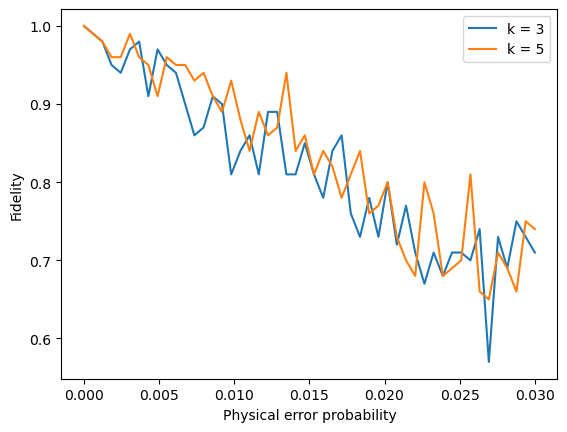

In [ ]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.linspace(0, 0.03, 50)

# success_rates_7x7 =  [execute_model(x_0,x_1,7,7,p,100, success=False) for p in error_rates]
success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p,100) for p in error_rates]
# success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p,100) for p in error_rates]
success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p,100) for p in error_rates]

plt.figure()
line1, = plt.plot(error_rates, success_rates_3x3, label='k = 3' )
# line2, = plt.plot(error_rates, success_rates_4x4, label='k = 4' )
line3, = plt.plot(error_rates, success_rates_5x5, label='k = 5' )
# line4, = plt.plot(error_rates, success_rates_7x7, label='k = 7' )

# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
plt.legend(handles=[line1,line3])

plt.ylabel("Fidelity")
plt.xlabel("Physical error probability")
plt.show()

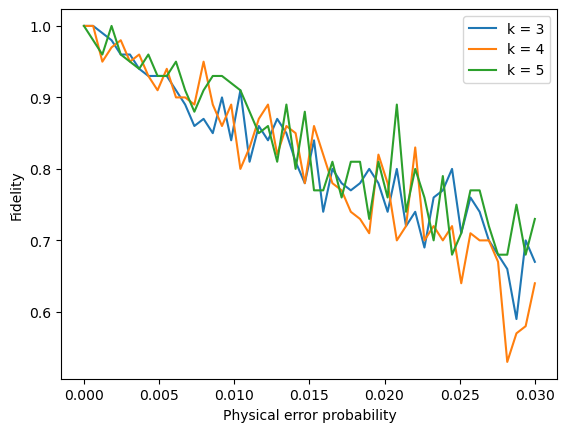

In [ ]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.linspace(0, 0.03, 50)

# success_rates_7x7 =  [execute_model(x_0,x_1,7,7,p,100, success=False) for p in error_rates]
success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p,100) for p in error_rates]
success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p,100) for p in error_rates]
success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p,100) for p in error_rates]

plt.figure()
line1, = plt.plot(error_rates, success_rates_3x3, label='k = 3' )
line2, = plt.plot(error_rates, success_rates_4x4, label='k = 4' )
line3, = plt.plot(error_rates, success_rates_5x5, label='k = 5' )
# line4, = plt.plot(error_rates, success_rates_7x7, label='k = 7' )

# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
plt.legend(handles=[line1,line2,line3])

plt.ylabel("Fidelity probability")
plt.xlabel("Physical error probability")
plt.show()

In [ ]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.linspace(0.005, 0.035, 50)

success_rates_7x7 =  [execute_model(x_0,x_1,7,7,p,150) for p in error_rates]
success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p,150) for p in error_rates]
# success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p,100) for p in error_rates]
success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p,150) for p in error_rates]

plt.figure()
line1, = plt.plot(error_rates, success_rates_3x3, label='k = 3' )
# line2, = plt.plot(error_rates, success_rates_4x4, label='k = 4' )
line3, = plt.plot(error_rates, success_rates_5x5, label='k = 5' )
line4, = plt.plot(error_rates, success_rates_7x7, label='k = 7' )

# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
plt.legend(handles=[line1,line3,line4])

plt.ylabel("Fidelity")
plt.xlabel("Physical error probability")
plt.show()

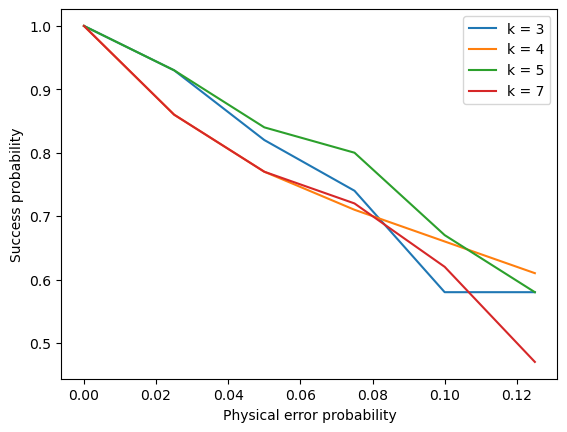

In [ ]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.arange(0.00, 0.15, 0.025)

success_rates_7x7 =  [execute_model(x_0,x_1,7,7,p,100) for p in error_rates]
success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p,100) for p in error_rates]
success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p,100) for p in error_rates]
success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p,100) for p in error_rates]

plt.figure()
line1, = plt.plot(error_rates, success_rates_3x3, label='k = 3' )
line2, = plt.plot(error_rates, success_rates_4x4, label='k = 4' )
line3, = plt.plot(error_rates, success_rates_5x5, label='k = 5' )
line4, = plt.plot(error_rates, success_rates_7x7, label='k = 7' )

# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
plt.legend(handles=[line1, line2, line3, line4])

plt.ylabel("Success probability")
plt.xlabel("Physical error probability")
plt.show()

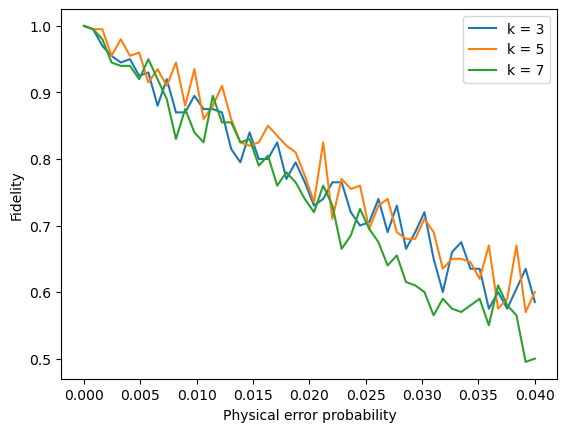

In [18]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.linspace(0, 0.04, 50)

success_rates_7x7 =  [execute_model(x_0,x_1,7,7,p,200) for p in error_rates]
success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p,200) for p in error_rates]
# success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p,200, success = False ) for p in error_rates]
success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p,200) for p in error_rates]

plt.figure()
line1, = plt.plot(error_rates, success_rates_3x3, label='k = 3' )
# line2, = plt.plot(error_rates, success_rates_4x4, label='k = 4' )
line3, = plt.plot(error_rates, success_rates_5x5, label='k = 5' )
line4, = plt.plot(error_rates, success_rates_7x7, label='k = 7' )

# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
plt.legend(handles=[line1,line3, line4])

plt.ylabel("Fidelity")
plt.xlabel("Physical error probability")
plt.show()

In [19]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.linspace(0.05, 0.25, 20)

success_rates_7x7 =  [execute_model(x_0,x_1,7,7,p,200) for p in error_rates]
# success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p,200) for p in error_rates]
# success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p,200, success = False ) for p in error_rates]
success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p,200) for p in error_rates]

plt.figure()
line1, = plt.plot(error_rates, success_rates_3x3, label='k = 3' )
# line2, = plt.plot(error_rates, success_rates_4x4, label='k = 4' )
# line3, = plt.plot(error_rates, success_rates_5x5, label='k = 5' )
line4, = plt.plot(error_rates, success_rates_7x7, label='k = 7' )

# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
plt.legend(handles=[line1, line4])

plt.ylabel("Fidelity")
plt.xlabel("Physical error probability")
plt.show()

KeyboardInterrupt: 

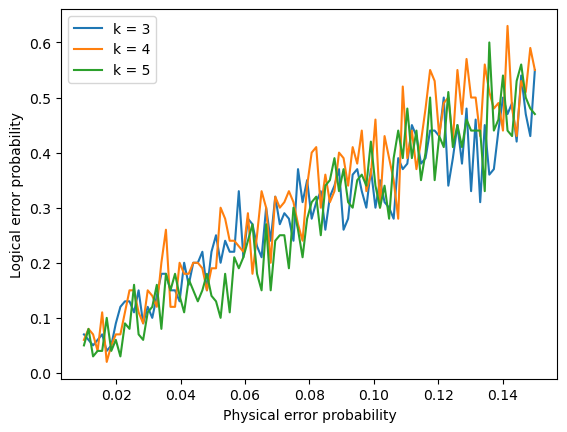

In [ ]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.linspace(0.01, 0.15, 100)

# success_rates_7x7 =  [execute_model(x_0,x_1,7,7,p,10, success=False) for p in error_rates]
success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p,100, success=False) for p in error_rates]
success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p,100, success = False ) for p in error_rates]
success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p,100, success=False) for p in error_rates]

plt.figure()
line1, = plt.plot(error_rates, success_rates_3x3, label='k = 3' )
line2, = plt.plot(error_rates, success_rates_4x4, label='k = 4' )
line3, = plt.plot(error_rates, success_rates_5x5, label='k = 5' )
# line4, = plt.plot(error_rates, success_rates_7x7, label='k = 7' )

# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
plt.legend(handles=[line1,line2, line3])

plt.ylabel("Logical error probability")
plt.xlabel("Physical error probability")
plt.show()

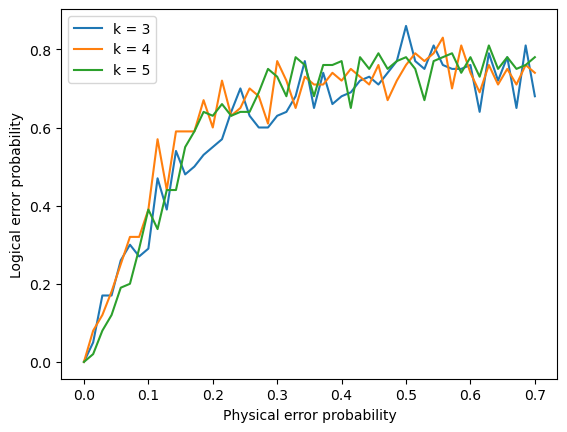

In [31]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.linspace(0, 0.7, 50)

# success_rates_7x7 =  [execute_model(x_0,x_1,7,7,p,10, success=False) for p in error_rates]
success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p,100, success=False) for p in error_rates]
success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p,100, success = False ) for p in error_rates]
success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p,100, success=False) for p in error_rates]

plt.figure()
line1, = plt.plot(error_rates, success_rates_3x3, label='k = 3' )
line2, = plt.plot(error_rates, success_rates_4x4, label='k = 4' )
line3, = plt.plot(error_rates, success_rates_5x5, label='k = 5' )
# line4, = plt.plot(error_rates, success_rates_7x7, label='k = 7' )

# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
plt.legend(handles=[line1,line2, line3])

plt.ylabel("Logical error probability")
plt.xlabel("Physical error probability")
plt.show()

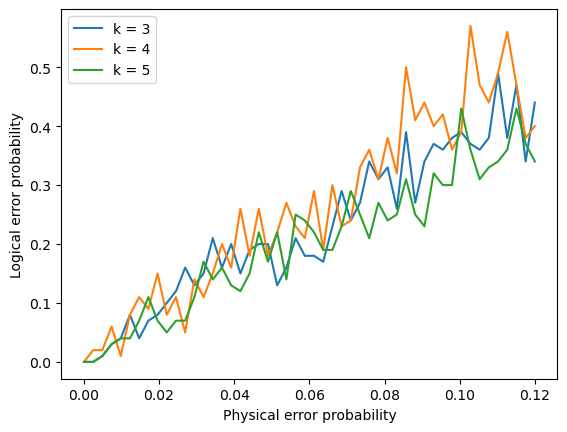

In [32]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.linspace(0, 0.12, 50)

# success_rates_7x7 =  [execute_model(x_0,x_1,7,7,p,10, success=False) for p in error_rates]
success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p,100, success=False) for p in error_rates]
success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p,100, success = False ) for p in error_rates]
success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p,100, success=False) for p in error_rates]

plt.figure()
line1, = plt.plot(error_rates, success_rates_3x3, label='k = 3' )
line2, = plt.plot(error_rates, success_rates_4x4, label='k = 4' )
line3, = plt.plot(error_rates, success_rates_5x5, label='k = 5' )
# line4, = plt.plot(error_rates, success_rates_7x7, label='k = 7' )

# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
plt.legend(handles=[line1,line2, line3])

plt.ylabel("Logical error probability")
plt.xlabel("Physical error probability")
plt.show()

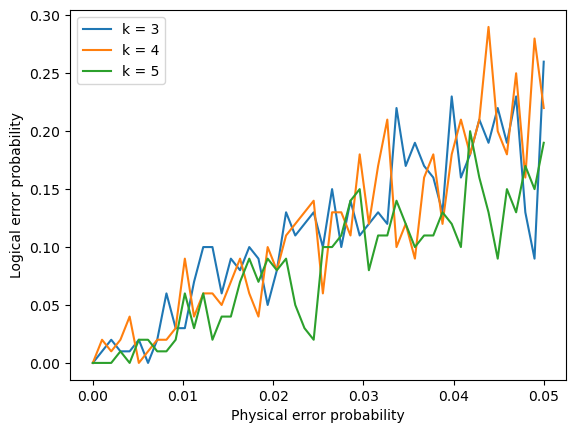

In [ ]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.linspace(0, 0.05, 50)

# success_rates_7x7 =  [execute_model(x_0,x_1,7,7,p,10, success=False) for p in error_rates]
success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p,100, success=False) for p in error_rates]
success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p,100, success = False ) for p in error_rates]
success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p,100, success=False) for p in error_rates]

plt.figure()
line1, = plt.plot(error_rates, success_rates_3x3, label='k = 3' )
line2, = plt.plot(error_rates, success_rates_4x4, label='k = 4' )
line3, = plt.plot(error_rates, success_rates_5x5, label='k = 5' )
# line4, = plt.plot(error_rates, success_rates_7x7, label='k = 7' )

# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
plt.legend(handles=[line1,line2, line3])

plt.ylabel("Logical error probability")
plt.xlabel("Physical error probability")
plt.show()

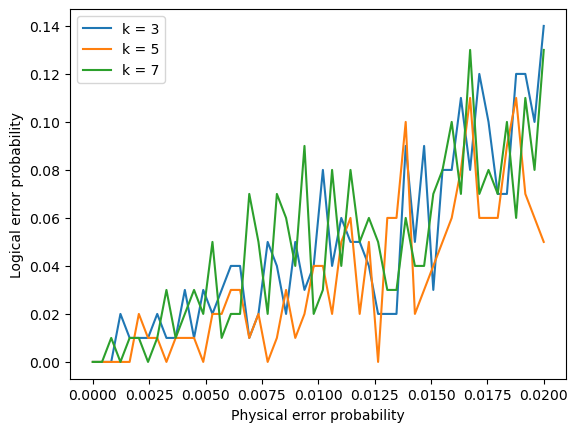

In [34]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.linspace(0, 0.02, 50)

success_rates_7x7 =  [execute_model(x_0,x_1,7,7,p,100, success=False) for p in error_rates]
success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p,100, success=False) for p in error_rates]
# success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p,100, success = False ) for p in error_rates]
success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p,100, success=False) for p in error_rates]

plt.figure()
line1, = plt.plot(error_rates, success_rates_3x3, label='k = 3' )
# line2, = plt.plot(error_rates, success_rates_4x4, label='k = 4' )
line3, = plt.plot(error_rates, success_rates_5x5, label='k = 5' )
line4, = plt.plot(error_rates, success_rates_7x7, label='k = 7' )

# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
plt.legend(handles=[line1,line3, line4])

plt.ylabel("Logical error probability")
plt.xlabel("Physical error probability")
plt.show()

In [ ]:
# x_0 = random.randint(0,1)
# x_1 = random.randint(0,1)
# error_rates = np.arange(0.00, 0.15, 0.005)

# success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p, success=False) for p in error_rates]
# success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p, success=False) for p in error_rates]
# success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p, success=False) for p in error_rates]

# plt.figure()
# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
# plt.legend(handles=[line1, line2, line3])
# plt.ylabel("Logical error probability")
# plt.xlabel("Physical error probability")
# plt.show()

Text(0.5, 0, 'Physical error probability')

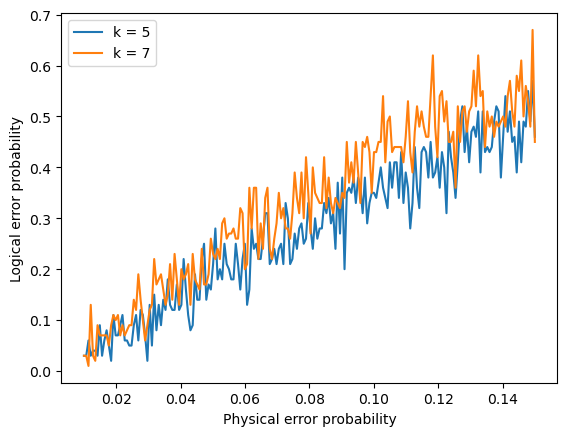

In [ ]:
line3, = plt.plot(error_rates, success_rates_5x5, label='k = 5' )
line4, = plt.plot(error_rates, success_rates_7x7, label='k = 7' )

# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
plt.legend(handles=[line3, line4])

plt.ylabel("Logical error probability")
plt.xlabel("Physical error probability")

In [ ]:
# x_0 = random.randint(0,1)
# x_1 = random.randint(0,1)
# error_rates = np.arange(0.025, 0.225, 0.025)

# success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p, success=False) for p in error_rates]
# success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p, success=False) for p in error_rates]
# success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p, success=False) for p in error_rates]

# plt.figure()
# line1, = plt.plot(*zip(*success_rates_3x3), label='k = 3' )
# line2, = plt.plot(*zip(*success_rates_4x4), label='k = 4' )
# line3, = plt.plot(*zip(*success_rates_5x5), label='k = 5 ' )
# plt.legend(handles=[line1, line2, line3])
# plt.ylabel("Logical error probability")
# plt.xlabel("Physical error probability")
# plt.show()

In [ ]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.arange(0.025, 0.225, 0.025)

success_rates_7x7 =  [execute_model(x_0,x_1,7,7,p, 1000, success=False) for p in error_rates]
success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p, 1000, success=False) for p in error_rates]
success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p, 1000, success=False) for p in error_rates]

plt.figure()

line1, = plt.plot(error_rates, success_rates_3x3, label='k = 3' )
line2, = plt.plot(error_rates, success_rates_5x5, label='k = 5' )
line3, = plt.plot(error_rates, success_rates_7x7, label='k = 7' )

plt.legend(handles=[line1, line2, line3])
plt.ylabel("Logical error probability")
plt.xlabel("Physical error probability")
plt.show()

In [ ]:

x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.arange(0.025, 0.225, 0.025)

success_rates_7x7 =  [execute_model(x_0,x_1,7,7,p, 100, success=False) for p in error_rates]
success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p, 100, success=False) for p in error_rates]
# success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p, 1000, success=False) for p in error_rates]

plt.figure()



line2, = plt.plot(error_rates, success_rates_5x5, label='k = 5' )
line3, = plt.plot(error_rates, success_rates_7x7, label='k = 7' )

# plt.legend(handles=[line1, line2, line3])
plt.ylabel("Logical error probability")
plt.xlabel("Physical error probability")
plt.show()


In [ ]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.arange(0.025, 0.225, 0.025)

success_rates_4x4 =  [execute_model(x_0,x_1,4,4,p, 1000, success=False) for p in error_rates]
success_rates_5x5 =  [execute_model(x_0,x_1,5,5,p, 1000, success=False) for p in error_rates]
success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p, 1000, success=False) for p in error_rates]

plt.figure()

line1, = plt.plot(error_rates, success_rates_3x3, label='k = 3' )
line2, = plt.plot(error_rates, success_rates_4x4, label='k = 4' )
line3, = plt.plot(error_rates, success_rates_5x5, label='k = 5' )

plt.legend(handles=[line1, line2, line3])
plt.ylabel("Logical error probability")
plt.xlabel("Physical error probability")
plt.show()

In [ ]:
# fig, axs = plt.subplots(1, 2) # Create a figure with 1 row and 2 columns of subplots

# # Label the first subplot
# axs[0].plot([1, 2, 3], [4, 5, 6])
# axs[0].set_title('Subplot A')
# axs[0].set_xlabel('X-axis A')
# axs[0].set_ylabel('Y-axis A')

# # Label the second subplot
# axs[1].plot([1, 2, 3], [6, 5, 4])
# axs[1].set_title('Subplot B')
# axs[1].set_xlabel('X-axis B')
# axs[1].set_ylabel('Y-axis B')

# plt.tight_layout() # Adjust layout to prevent labels from overlapping
# plt.show()

In [ ]:
# x_0 = 0
# x_1 = 1

# error_params = np.arange(0.00, 0.25, 0.01)
# success_rates =  [execute_model(x_0,x_1,3,3,p) for p in error_params]

# plt.scatter(*zip(*success_rates))
# plt.ylabel("Success rate probability")
# plt.xlabel("Error rate probability")
# plt.show()

In [ ]:
# elarge = [(u, v) for (u, v, d) in plaquette_graph.edges(data=True) if d["weight"] > 0.5]
# esmall = [(u, v) for (u, v, d) in plaquette_graph.edges(data=True) if d["weight"] <= 0.5]

# pos = nx.spring_layout(plaquette_graph, seed=7)  # positions for all nodes - seed for reproducibility

# # nodes
# nx.draw_networkx_nodes(plaquette_graph, pos, node_size=700)

# # edges
# nx.draw_networkx_edges(plaquette_graph, pos, edgelist=elarge, width=6)
# nx.draw_networkx_edges(
#     plaquette_graph, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
# )

# # node labels
# nx.draw_networkx_labels(plaquette_graph, pos, font_size=20, font_family="sans-serif")
# # edge weight labels
# edge_labels = nx.get_edge_attributes(plaquette_graph, "weight")
# nx.draw_networkx_edge_labels(plaquette_graph, pos, edge_labels)

In [ ]:
pmin = 0.01; pmax = 0.2; pts = 50
p_arr = np.linspace(pmin, pmax, pts)

error_rates = np.arange(0.025, 0.225, 0.025)
print(error_rates)
print(p_arr)

[0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2  ]
[0.01       0.01387755 0.0177551  0.02163265 0.0255102  0.02938776
 0.03326531 0.03714286 0.04102041 0.04489796 0.04877551 0.05265306
 0.05653061 0.06040816 0.06428571 0.06816327 0.07204082 0.07591837
 0.07979592 0.08367347 0.08755102 0.09142857 0.09530612 0.09918367
 0.10306122 0.10693878 0.11081633 0.11469388 0.11857143 0.12244898
 0.12632653 0.13020408 0.13408163 0.13795918 0.14183673 0.14571429
 0.14959184 0.15346939 0.15734694 0.16122449 0.16510204 0.16897959
 0.17285714 0.17673469 0.18061224 0.1844898  0.18836735 0.1922449
 0.19612245 0.2       ]
